# Introducción a las redes RNN-LSTM 
### Análisis bidimensional y a un paso de las series de tiempo del precio de Bitcoin y Ethereum.

## Contenido
### 1. Mostrando código para evitar desconección del cuaderno de Colab.
### 2. Importando paquetes y usando pandas_datareader para importar datos del Bitcoin y Etherium.
### 3. Creación y explicación de la función "multivariate_data()" para la preparación de datos.
### 4. Preparación de los datos, modificando su formato y creación del modelo (RNN-LSTM).
### 5. Definición y uso de funciones graficadoras.
### 6. Creación, entrenamiento y grabación de datos de predicción de modelos con 8, 128 y 256 neuronas en su capa intermedia y posterior eliminación del modelo.
### 7. Graficas perdida vs epochs.
### 8. Gráfica y resultados comparativos de las predicciones de los 3 modelos.

In [ ]:
#Source: https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82#0d57
#Stop Colab from disconecting:
#ctl+shift+i -> console -> command lines:
#Ctrl+ Shift + i to open inspector view . Then goto console.

function ConnectButton(){
    console.log("Working"); 
    document.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

### *Importando paquetes:*

In [1]:
#To import data
!pip install pandas_datareader #For COLAB
import pandas_datareader.data as web
#Data managing
import numpy as np
import os
import pandas as pd
#To comparison forecasts
from sklearn.metrics import mean_squared_error
#Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
#RNN
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

#I dont know for what are these packages
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

#Setting figure size
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

Tensorflow Version: 2.5.0
Pandas Version: 1.1.5
Numpy Version: 1.19.5
System Version: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


### *Importando y visualizando datos del bitcoin:*


In [2]:
#bivariate time series
#starDate="2017-01-01" #year-month-day
#endDate="2017-04-30"
data = web.DataReader(["BTC-USD", "ETH-USD"], 'yahoo')#, "yahoo", start=starDate, end=endDate)
features = data['Adj Close']
#print(type(btc_usd))
print(data.head())
print(features.head())
#btc_usd.sort_index(ascending=False).head()
#NOTE: Check that index is date by default

Attributes   Adj Close             ...       Volume            
Symbols        BTC-USD    ETH-USD  ...      BTC-USD     ETH-USD
Date                               ...                         
2016-06-11  672.783997  15.743700  ...  277084992.0  38210300.0
2016-06-12  704.375977  17.602699  ...  243295008.0  38023400.0
2016-06-13  685.559021  18.893200  ...  186694000.0  64412200.0
2016-06-14  694.468994  18.354300  ...   99223800.0  19393400.0
2016-06-15  766.307983  20.588600  ...  271633984.0  38531000.0

[5 rows x 12 columns]
Symbols        BTC-USD    ETH-USD
Date                             
2016-06-11  672.783997  15.743700
2016-06-12  704.375977  17.602699
2016-06-13  685.559021  18.893200
2016-06-14  694.468994  18.354300
2016-06-15  766.307983  20.588600


## (Opcional):
En caso de presentar problemas importando los datos con 'web.DataReader()' se pueden usar los siguientes métodos:

In [ ]:
#DEL
import yfinance as yf

from pandas_datareader import data as pdr

yf.pdr_override() # <== that's all it takes :-)

#Univariate time series
#One way - get_data_yahoo:
btc_usd = pdr.get_data_yahoo("BTC-USD", "ETH-USD")
print(type(btc_usd))
btc_usd.head()
#btc_usd.sort_index(ascending=False).head()



ModuleNotFoundError: ignored

## Registros diarios (uno por día) y graficando los datos
Como se puede ver hay se tienen 1822 registros diarios del Bitcoin (desde el 2016 hasta la fecha):

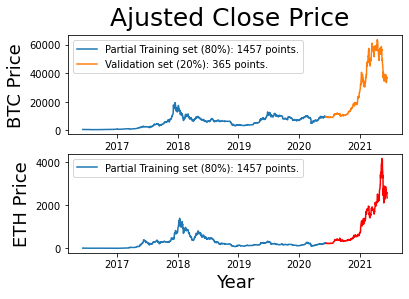

Attributes     Adj Close               ...        Volume              
Symbols          BTC-USD      ETH-USD  ...       BTC-USD       ETH-USD
count        1822.000000  1822.000000  ...  1.822000e+03  1.822000e+03
mean        10276.046142   423.612916  ...  1.708713e+10  7.981786e+09
std         12663.917687   597.567378  ...  2.124493e+10  1.097351e+10
min           547.465027     6.821660  ...  3.397780e+07  3.505990e+06
25%          3601.375366   133.996384  ...  1.912078e+09  8.771630e+08
50%          7277.461182   226.353004  ...  8.414029e+09  3.128197e+09
75%         10233.825195   432.214005  ...  2.459978e+10  1.061966e+10
max         63503.457031  4168.701172  ...  3.509679e+11  8.448291e+10

[8 rows x 12 columns]


In [3]:
data = web.DataReader(["BTC-USD", "ETH-USD"], 'yahoo')#, "yahoo", start=starDate, end=endDate)
features = data['Adj Close']

#Hiperparameter
TRAIN_SPLIT = int(len(features)*0.8)
#print(TRAIN_SPLIT)

#if it does not work, includ date as index
fig, axs = plt.subplots(2)
fig.suptitle("Ajusted Close Price", size=25)
#----- Bitcoin plot ---------
axs[0].set_ylabel('BTC Price', fontsize=18)
axs[0].plot(features['BTC-USD'][:TRAIN_SPLIT], label="Partial Training set (80%): "+str(TRAIN_SPLIT)+" points.")
axs[0].plot(features['BTC-USD'][TRAIN_SPLIT:], label="Validation set (20%): "+str(len(features)-TRAIN_SPLIT)+" points.")
axs[0].legend()
#----- Ethereum plot ---------
axs[1].set_ylabel('ETH Price', fontsize=18)
axs[1].plot(features['ETH-USD'][:TRAIN_SPLIT], label="Partial Training set (80%): "+str(TRAIN_SPLIT)+" points.")
axs[1].plot(features['ETH-USD'][TRAIN_SPLIT:], color="red")#, label="Validation set (20%): "+str(len(features)-TRAIN_SPLIT)+" points.")
axs[1].legend()
axs[1].set_xlabel('Year', fontsize = 18)
plt.show()
print(data.describe())


## Estandarización (Crear una función *Candidata a exportar*).
Nota: se hace con los datos de entrenamiento.

In [4]:
#Getting mean and std
dataset = features.values
#print(dataset)
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
#print(data_mean)
#print(data_std)

#standarized dataset
dataset = (dataset-data_mean)/data_std
print(dataset)
print(dataset.dtype)
print(dataset[:,0]) #To understand 'target' in single step model


[[-1.3523248  -0.97477007]
 [-1.34392363 -0.96686624]
 [-1.34892757 -0.96137947]
 ...
 [ 8.39983953 10.04775719]
 [ 8.22897521  9.46634895]
 [ 8.27838881  8.91642749]]
float64
[-1.3523248  -1.34392363 -1.34892757 ...  8.39983953  8.22897521
  8.27838881]


# Single step model: basado en una historia dada (varios datos pasados) predecir un solo dato en el futuro.

### Función de preparación de datos multivariada (ya estandarizados o normalizados) para análisis univariado (*candidata a exportar*) (singlestep model):

- label: Precio del bitcoin

In [5]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
  '''
      dataset: Data "matrix" containing the all time series (stadarized or not)
      target: Data (point in single step model) to predict
      start_index: index from where data start to analize
      end_index: final index to take data. None is to take all data
      history_size: window size to create sequence (and then used to predict)
      target_size: position of point in future 'until where' (hasta donde) to predict
      step: (Provitional) step(1,2,etc) in indices to take data from dataset
      single_step: TRUE=>single step model FALSE=> multi step model
  '''
  data = []
  labels = []
  
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i-history_size,i,step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      label.append(target[i:i+target_size])
  
  return np.array(data), np.array(labels)

#print(len(range(0,10,2)))

In [ ]:
#Understanding 'STEP' (NOTE: STEP must be >= 1)
step_test = 1
#print(len(range(0,10,0)))
print(len(range(0,10,1)))
print(len(range(0,10,2)))

10
5


## Obteniendo los datos en el formato adecuado para trabajar

In [6]:
#def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False)
past_history = 20
future_target = 1 #steps in future 'until where' to predict
STEP = 1#6

#training data
x_train_single_2D, y_train_single_2D = multivariate_data(dataset=dataset, target=dataset[:,0],
                                                   start_index=0, end_index=TRAIN_SPLIT, history_size = past_history,
                                                   target_size=future_target, step=STEP, single_step=True)

#validation data
x_val_single_2D, y_val_single_2D = multivariate_data(dataset=dataset, target=dataset[:,0],
                                               start_index=TRAIN_SPLIT, end_index=None, history_size = past_history,
                                               target_size=future_target, step=STEP, single_step=True)

#Checking shape
print(dataset.shape)
print(x_train_single_2D.shape)
print(x_train_single_2D.shape[-2:])
print(y_train_single_2D.shape)
print(x_train_single_2D.dtype)


(1822, 2)
(1437, 20, 2)
(20, 2)
(1437,)
float64


## (Hiper)Parámetros para la red LSTM

In [7]:
#Data load params
BATCH_SIZE = 256
BUFFER_SIZE = 10000
#TRAIN_SPLIT = int(len(btc_usd)*0.8) #Put before
#print(TRAIN_SPLIT)
#print(type(TRAIN_SPLIT))
#print(2424*0.8)

#LSTM params
EVALUATION_INTERVAL = 200 #FOR WHAT?
EPOCHS = 100
PATIENCE = 5 #FOR WHAT?

#Seeding for reproducibility
SEED = 13
tf.random.set_seed(SEED)


## Modificando el formato de los datos usando TensorFlow para el uso de RNN-LSTM

In [8]:
#Train data
train_single_2D = tf.data.Dataset.from_tensor_slices((x_train_single_2D,y_train_single_2D))
train_single_2D = train_single_2D.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#Validation data
val_single_2D = tf.data.Dataset.from_tensor_slices((x_val_single_2D,y_val_single_2D))
val_single_2D = val_single_2D.batch(BATCH_SIZE).repeat()

print(train_single_2D)
print(val_single_2D)
print(val_single_2D.take(1))

<RepeatDataset shapes: ((None, 20, 2), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 2), (None,)), types: (tf.float64, tf.float64)>
<TakeDataset shapes: ((None, 20, 2), (None,)), types: (tf.float64, tf.float64)>


### Definiendo funciones (*candidatas a exportar*) para graficar prediccion y pérdida

In [17]:
def create_time_steps(length):
  return list(range(-length,0))

def plot_short_pred(plot_data, delta, title):
  #This function plots 3 things: History, true future and prediction
  '''
      plot_data (list): [x,y,z]: data to plot in function of time (time_steps).
      delta: (0 = False & 1 = True) I think related with 'univariate_future_target' 
      title (str): plot title.
  '''
  #print(type(plot_data))
  #print(plot_data[0])
  #print(plot_data[0].flatten())
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  #print(plot_data[0].shape[0])
  #print(plot_data[0].shape)
  if delta:
    future = delta
  else:
    future = 0
  plt.title(title, size=20)
  
  for i,x in enumerate(plot_data): #enumerate(plot_data) = (0,x_train),(1,y_train)
    #Note: i = 0 is false, the rest (i.e. i=300) is true
    if i: #(i = 1)
      plt.plot(future, plot_data[i], marker[i],markersize=10, label=labels[i]) #Plotting true future
    else: #(i=0)
      plt.plot(time_steps,plot_data[i].flatten(),marker[i], label=labels[i]) #Plotting History
    plt.legend()
    plt.xlim([time_steps[0], (future+4)*2])
    plt.xlabel('Time-Step', size=16)
    plt.ylabel("Standardized Price [A.U.]", size=16)

  return plt

#Testing function #not working next row
#plot_short_pred(plot_data=[x_train_single_2D[0][:,1].numpy(), y_train_single_2D[0][:,1].numpy()], 0, 'Sample Example')

## Función que gráfica la perdida en los datos de entrenamiento y validación

In [10]:
def plot_loss(history, title):
  #print(history.history)
  loss = history.history['loss']
  #print(loss)
  val_loss = history.history['val_loss']
  #print(val_loss)

  epochs = range(len(loss))
  #print(epochs)

  #1st y axis (training loss)
  fig, ax1 = plt.subplots()
  col1 = "red"
  ax1.set_xlabel("Epoch", size=15)
  ax1.set_ylabel("Training Loss", color=col1, size=20)
  ax1.plot(epochs,loss, color=col1, marker = 'o')
  ax1.tick_params(axis='y', labelcolor=col1)

  #2nd y axis (val loss)
  ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
  col2 = "blue"
  ax2.set_ylabel("Val. Loss", color=col2, size=20)
  ax2.plot(epochs, val_loss, color=col2, marker = "o")
  ax2.tick_params(axis='y', labelcolor=col2)
  plt.title(title, size=19)
  #fig.tight_layout()
  plt.show()

## Función de creación del modelo RNN-LSTM con un número de neuronas dado (*Candidata a exportar*)

In [11]:
def my_model(n_of_neurons, in_shape):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(units=n_of_neurons, input_shape=in_shape))
  model.add(tf.keras.layers.Dense(1))
  return model

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 8 neuronas en su capa intermedia.

In [12]:
%%time
#in_shape=x_train_single_2D.shape[-2:]
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=8, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
#What does steps_per_epoch= mean ? why 200 'steps' ?
#What does validation= mean ? why 200 'steps' ?
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping], validation_steps=50)

#PREDICTIONS
predictions8U = single_step_2D_model.predict(x_val_single_2D)

Evaluation Threshold: 200
Epochs: 100
Epoch 1/100
200/200 [==============================] - 9s 7ms/step - loss: 0.3934 - val_loss: 5.5477
Epoch 2/100
200/200 [==============================] - 1s 5ms/step - loss: 0.1124 - val_loss: 4.4711
Epoch 3/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0867 - val_loss: 4.2262
Epoch 4/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0794 - val_loss: 4.1324
Epoch 5/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0758 - val_loss: 4.0869
Epoch 6/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0736 - val_loss: 4.0548
Epoch 7/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0720 - val_loss: 4.0382
Epoch 8/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0710 - val_loss: 4.0240
Epoch 9/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0701 - val_loss: 4.0214
Epoch 10/100
200/200 [==============================]

### Gráfica de la pérdida en función de las epochs

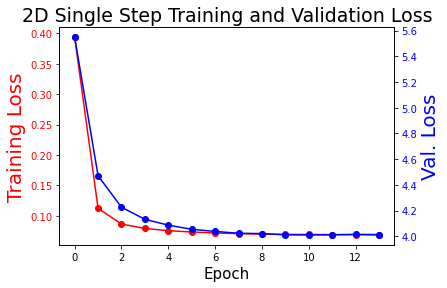

In [13]:
plot_loss(history=single_step_2D_history, title='2D Single Step Training and Validation Loss')

In [18]:
#Checking sample prediction shape
for x,y in val_single_2D.take(1):
  print(single_step_2D_model.predict(x).shape)

(256, 1)


In [25]:
for x,y in val_single_2D.take(2):
  plot = plot_short_pred(plot_data=[x[0][:,1].numpy(), y[0].numpy(), single_step_2D_model.predict(x)[0]], delta=0, title='Single 2D LSTM Model')
  plot.show()

NameError: ignored

In [20]:
#deleting model
del single_step_2D_model

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 128 neuronas en su capa intermedia.

In [21]:
%%time
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=128, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping], validation_steps=50)

#PREDICTIONS
predictions128U = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model

Epoch 1/100
200/200 [==============================] - 3s 7ms/step - loss: 0.1275 - val_loss: 2.1798
Epoch 2/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0889 - val_loss: 1.8447
Epoch 3/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0793 - val_loss: 1.8844
Epoch 4/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0741 - val_loss: 2.0492
Epoch 5/100
200/200 [==============================] - 1s 5ms/step - loss: 0.0705 - val_loss: 2.1489
CPU times: user 8.9 s, sys: 625 ms, total: 9.53 s
Wall time: 8.02 s


### Gráfica de la pérdida en función de las epochs

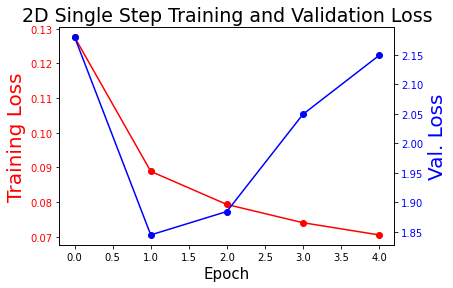

In [22]:
plot_loss(history=single_step_2D_history, title='2D Single Step Training and Validation Loss')

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 256 neuronas en su capa intermedia.

In [23]:
%%time
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=256, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping], validation_steps=50)

#PREDICTIONS
predictions256U = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model

Epoch 1/100
200/200 [==============================] - 3s 9ms/step - loss: 0.1354 - val_loss: 1.3264
Epoch 2/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0910 - val_loss: 1.2491
Epoch 3/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0817 - val_loss: 1.7377
Epoch 4/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0765 - val_loss: 1.9197
Epoch 5/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0729 - val_loss: 1.9848
CPU times: user 9.14 s, sys: 568 ms, total: 9.71 s
Wall time: 9.07 s


### Gráfica de la pérdida en función de las epochs

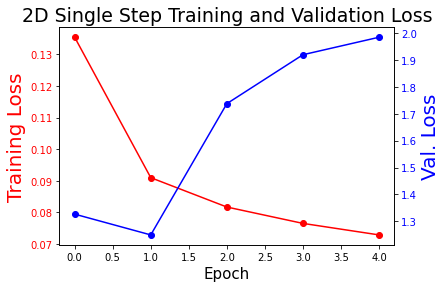

In [24]:
plot_loss(history=single_step_2D_history, title='2D Single Step Training and Validation Loss')

## Graficando predicciones y función MSE

### Configurando dataframes para obtener series de tiempo (y no solo arrays):

In [26]:
#To plot part of the train and validation data (from BTC only) together with models predictions

#------- Creating dframes (to work with time series) with standirized data
#dframes lengths
N = len(features)
M = len(predictions8U)
#print(N)
#print(M)

#data dataframe
data_std = pd.DataFrame(index=data.index, columns=['AdjCloStd'])
train_part = data_std[:TRAIN_SPLIT] #Not all train data, but just bitcoin train data
valid = data_std[TRAIN_SPLIT:]
#print(train_part)

#predictions dataframe
predictions = pd.DataFrame(index=data.tail(M).index, columns=['Pred8U','Pred128U','Pred256U'])

#print(features['BTC-USD'][1])
#Filling data dataframe
for i in range(0,N):
  data_std['AdjCloStd'][i] = dataset[:,0][i]#features['BTC-USD'][i]#uni_data#0 column is for btc_usd#

#print(train_part)
#print(data_std)
#NOTE: it is strange to me that train_part has something and it was not filled explicitely

#Filling predictions dataframe
predictions['Pred8U'] = predictions8U
predictions['Pred128U'] = predictions128U
predictions['Pred256U'] = predictions256U

### Graficando serie de tiempo y predicciones:

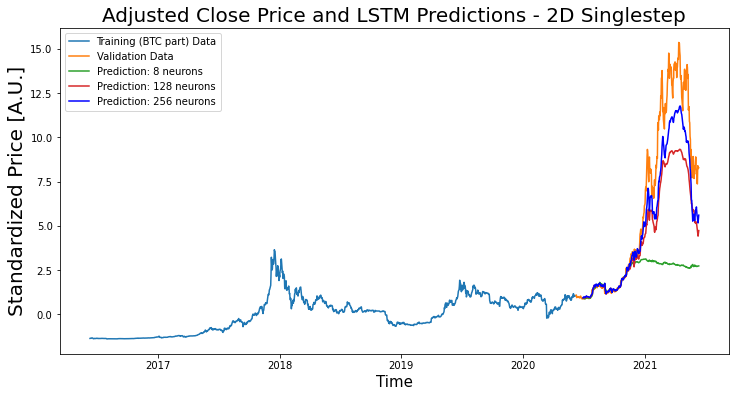

In [30]:
plt.figure(figsize=(12,6))
plt.plot(train_part['AdjCloStd'], label="Training (BTC part) Data")
plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(predictions['Pred8U'], label="Prediction: 8 neurons")
plt.plot(predictions['Pred128U'], label="Prediction: 128 neurons")
plt.plot(predictions['Pred256U'], label="Prediction: 256 neurons", color='blue')
plt.title("Adjusted Close Price and LSTM Predictions - 2D Singlestep", size=20)
plt.ylabel("Standardized Price [A.U.]", size=20)
plt.xlabel("Time", size=15)
plt.legend()
plt.show()

### Graficando datos de validación y predicciones

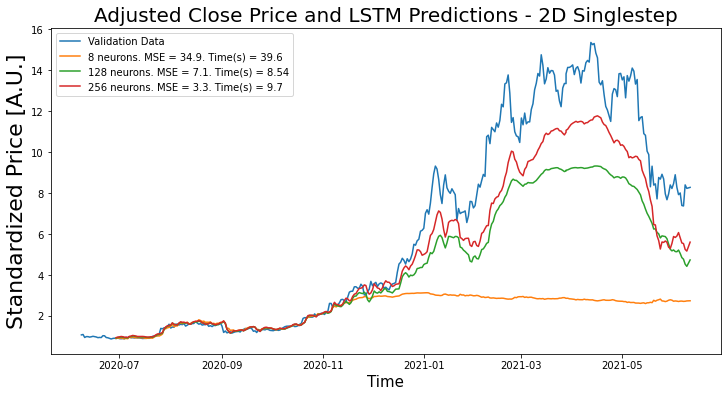

In [31]:
#training time
T_8U = 39.6
T_128U = 8.54
T_256U = 9.7

#MSE Calculations
MSE_8U = round(mean_squared_error(y_val_single_2D, predictions8U , squared=True),1)
MSE_128U = round(mean_squared_error(y_val_single_2D, predictions128U , squared=True),1)
MSE_256U = round(mean_squared_error(y_val_single_2D, predictions256U, squared=True),1)

#Plotting
plt.figure(figsize=(12,6))
plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(predictions['Pred8U'], label="8 neurons. MSE = "+str(MSE_8U)+". Time(s) = "+str(T_8U))
plt.plot(predictions['Pred128U'], label="128 neurons. MSE = "+str(MSE_128U)+". Time(s) = "+str(T_128U))
plt.plot(predictions['Pred256U'], label="256 neurons. MSE = "+str(MSE_256U)+". Time(s) = "+str(T_256U))
plt.title("Adjusted Close Price and LSTM Predictions - 2D Singlestep", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time", size=15)
plt.legend()
plt.show()
#NOTE: Destadarization NOT DONE

# Por que con muchas neuronas (desde 512 hacia arriba) el resultado de la predicción cambiaba mucho al correr el modelo varias veces?
# NOTE: Cambiar los nombres de las variables de acuerdo al número de neuronas en la capa intermedia de cada modelo

#Para 256 neuronas:


In [45]:
%%time
units=256
###################### 1ND MODEL ##################################
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping], validation_steps=50)

#PREDICTIONS
predictions512U_1 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model

###################### 2ND MODEL ##################################
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping], validation_steps=50)

#PREDICTIONS
predictions512U_2 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model

###################### 3RD MODEL ##################################
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping], validation_steps=50)

#PREDICTIONS
predictions512U_3 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model

Epoch 1/100
200/200 [==============================] - 3s 9ms/step - loss: 0.1341 - val_loss: 1.6187
Epoch 2/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0912 - val_loss: 1.7475
Epoch 3/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0821 - val_loss: 1.7805
Epoch 4/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0766 - val_loss: 1.4732
Epoch 5/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0724 - val_loss: 1.8936
Epoch 6/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0693 - val_loss: 2.2743
Epoch 7/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0662 - val_loss: 2.5870
Epoch 1/100
200/200 [==============================] - 3s 9ms/step - loss: 0.1329 - val_loss: 1.6718
Epoch 2/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0922 - val_loss: 1.3638
Epoch 3/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0823 - val_los

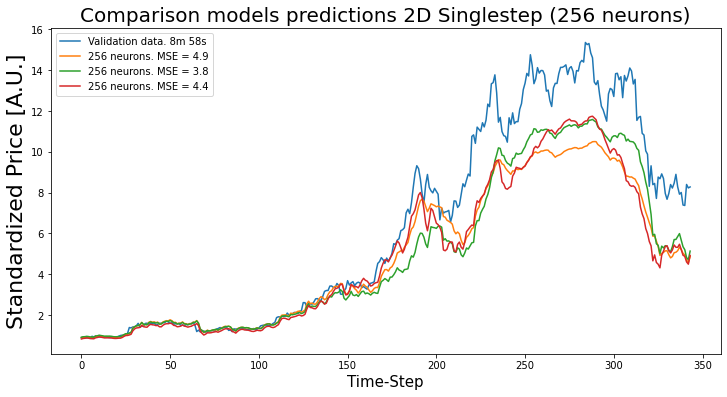

In [50]:
###################### PLOTTING ##################################
#MSE Calculations
MSE_2048U_1 = round(mean_squared_error(y_val_single_2D, predictions512U_1 , squared=True),1)
MSE_2048U_2 = round(mean_squared_error(y_val_single_2D, predictions512U_2 , squared=True),1)
MSE_2048U_3 = round(mean_squared_error(y_val_single_2D, predictions512U_3 , squared=True),1) 


#Plotting
plt.figure(figsize=(12,6))
plt.plot(y_val_single_2D, label="Validation data. 8m 58s")
plt.plot(predictions512U_1, label="256 neurons. MSE = "+str(MSE_2048U_1))
plt.plot(predictions512U_2, label="256 neurons. MSE = "+str(MSE_2048U_2))
plt.plot(predictions512U_3, label="256 neurons. MSE = "+str(MSE_2048U_3))
plt.title("Comparison models predictions 2D Singlestep (256 neurons)", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time-Step", size=15)
plt.legend()
plt.show()

#Para 1024 neuronas(problemático):


In [48]:
%%time
units=1024
###################### 1ND MODEL ##################################
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping], validation_steps=50)

#PREDICTIONS
predictions2048U_1 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model

###################### 2ND MODEL ##################################
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping], validation_steps=50)

#PREDICTIONS
predictions2048U_2 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model

###################### 3RD MODEL ##################################
#CREATING MODEL
single_step_2D_model = my_model(n_of_neurons=units, in_shape=x_train_single_2D.shape[-2:])
single_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
single_step_2D_history = single_step_2D_model.fit(train_single_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_single_2D, callbacks=[early_stopping], validation_steps=50)

#PREDICTIONS
predictions2048U_3 = single_step_2D_model.predict(x_val_single_2D)

#deleting model
del single_step_2D_model

Epoch 1/100
200/200 [==============================] - 10s 43ms/step - loss: 0.2537 - val_loss: 1.6571
Epoch 2/100
200/200 [==============================] - 8s 41ms/step - loss: 0.1181 - val_loss: 0.8357
Epoch 3/100
200/200 [==============================] - 8s 42ms/step - loss: 0.0968 - val_loss: 1.6799
Epoch 4/100
200/200 [==============================] - 9s 43ms/step - loss: 0.0872 - val_loss: 2.0185
Epoch 5/100
200/200 [==============================] - 9s 43ms/step - loss: 0.0809 - val_loss: 2.6346
Epoch 1/100
200/200 [==============================] - 10s 45ms/step - loss: 0.2432 - val_loss: 2.3634
Epoch 2/100
200/200 [==============================] - 9s 43ms/step - loss: 0.1164 - val_loss: 1.6024
Epoch 3/100
200/200 [==============================] - 9s 43ms/step - loss: 0.0929 - val_loss: 1.8343
Epoch 4/100
200/200 [==============================] - 9s 43ms/step - loss: 0.0831 - val_loss: 2.0783
Epoch 5/100
200/200 [==============================] - 8s 42ms/step - loss: 0.07

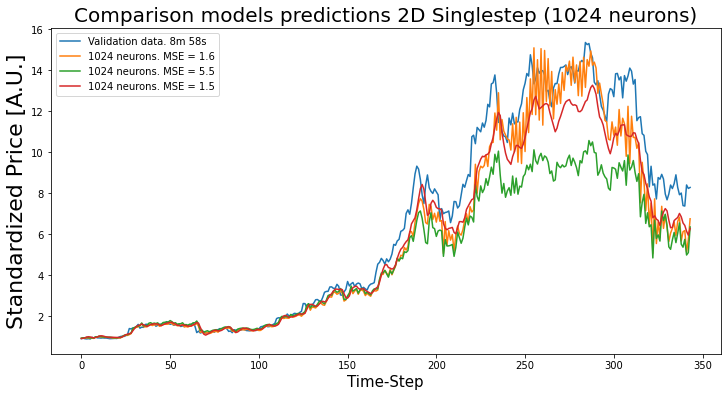

In [52]:
###################### PLOTTING ##################################
#MSE Calculations
MSE_2048U_1 = round(mean_squared_error(y_val_single_2D, predictions2048U_1 , squared=True),1)
MSE_2048U_2 = round(mean_squared_error(y_val_single_2D, predictions2048U_2 , squared=True),1)
MSE_2048U_3 = round(mean_squared_error(y_val_single_2D, predictions2048U_3 , squared=True),1) 


#Plotting
plt.figure(figsize=(12,6))
#plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(y_val_single_2D, label="Validation data. 8m 58s")
plt.plot(predictions2048U_1, label="1024 neurons. MSE = "+str(MSE_2048U_1))
plt.plot(predictions2048U_2, label="1024 neurons. MSE = "+str(MSE_2048U_2))
plt.plot(predictions2048U_3, label="1024 neurons. MSE = "+str(MSE_2048U_3))
plt.title("Comparison models predictions 2D Singlestep (1024 neurons)", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time-Step", size=15)
plt.legend()
plt.show()

## Cambiar todo lo que sigue (bibliografia)
## Cosas pendientes:
1. Hacer modelos multivariados con mas neuronas
2. Hacer modelos multipaso

## Conclusiones:
1. El modelo logra mejores predicciones cuando tiene mas neuronas en su capa intermedia hasta las 256 neuronas.
2. Modelos con 1024 neuronas (en el modelo unidemensional eran 512) o mas arrojan predicciones variables. Es decir distintas predicciones cuando se compilan distintas veces.(ESTO SE ESPERA, PERO EN EL MODELO BIDIMENSIONAL NO SE HA VERIFICADO) (ESTO TOCA ESTUDIARLO MAS, YA QUE NO ESTAMOS SEGUROS SI EL NÚMERO ES DE 1024 NEURONAS)
3. El modelo unidimensional arroja mejores predicciones que el modelo bidimensional. Este resultado es contrario al que se esperaba obtener.

## Bibliografía

### Redes RNN-LSTM (cuaderno).
1. [Introducción a Keras LSTM para series de tiempo multivariadas. Montenegro et.al.](https://nbviewer.jupyter.org/github/AprendizajeProfundo/Diplomado/blob/master/Temas/M%C3%B3dulo%205-%20Redes%20recurrentes/Cuadernos/rnrTimes_series_Multivariate.ipynb).
1. A. [Keras Timeseries Multi-Step Multi-Output](https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output).

### Yahoo Finance (datos importados).
2. [Yahoo Finance API – A Complete Guide](https://algotrading101.com/learn/yahoo-finance-api-guide/)
3. [yfinance Library – A Complete Guide](https://algotrading101.com/learn/yfinance-guide/)
4. [yfinance documentation](https://pypi.org/project/yfinance/)

